Epoch 1/5: 100%|██████████| 72/72 [00:38<00:00,  1.86it/s, Train Loss=0.29] 


Epoch 1/5 - Train Loss: 0.2896, Test Loss: 0.2010, Accuracy: 0.9258, Precision: 0.9529, Recall: 0.8980, F1 Score: 0.9246


Epoch 2/5: 100%|██████████| 72/72 [00:37<00:00,  1.90it/s, Train Loss=0.137]


Epoch 2/5 - Train Loss: 0.1367, Test Loss: 0.1787, Accuracy: 0.9308, Precision: 0.9730, Recall: 0.8882, F1 Score: 0.9286


Epoch 3/5: 100%|██████████| 72/72 [00:38<00:00,  1.88it/s, Train Loss=0.0544]


Epoch 3/5 - Train Loss: 0.0544, Test Loss: 0.1536, Accuracy: 0.9492, Precision: 0.9628, Recall: 0.9359, F1 Score: 0.9491


Epoch 4/5: 100%|██████████| 72/72 [00:38<00:00,  1.88it/s, Train Loss=0.0215]


Epoch 4/5 - Train Loss: 0.0215, Test Loss: 0.1780, Accuracy: 0.9492, Precision: 0.9643, Recall: 0.9342, F1 Score: 0.9490


Epoch 5/5: 100%|██████████| 72/72 [00:38<00:00,  1.89it/s, Train Loss=0.0141] 


Epoch 5/5 - Train Loss: 0.0141, Test Loss: 0.1961, Accuracy: 0.9483, Precision: 0.9520, Recall: 0.9457, F1 Score: 0.9488


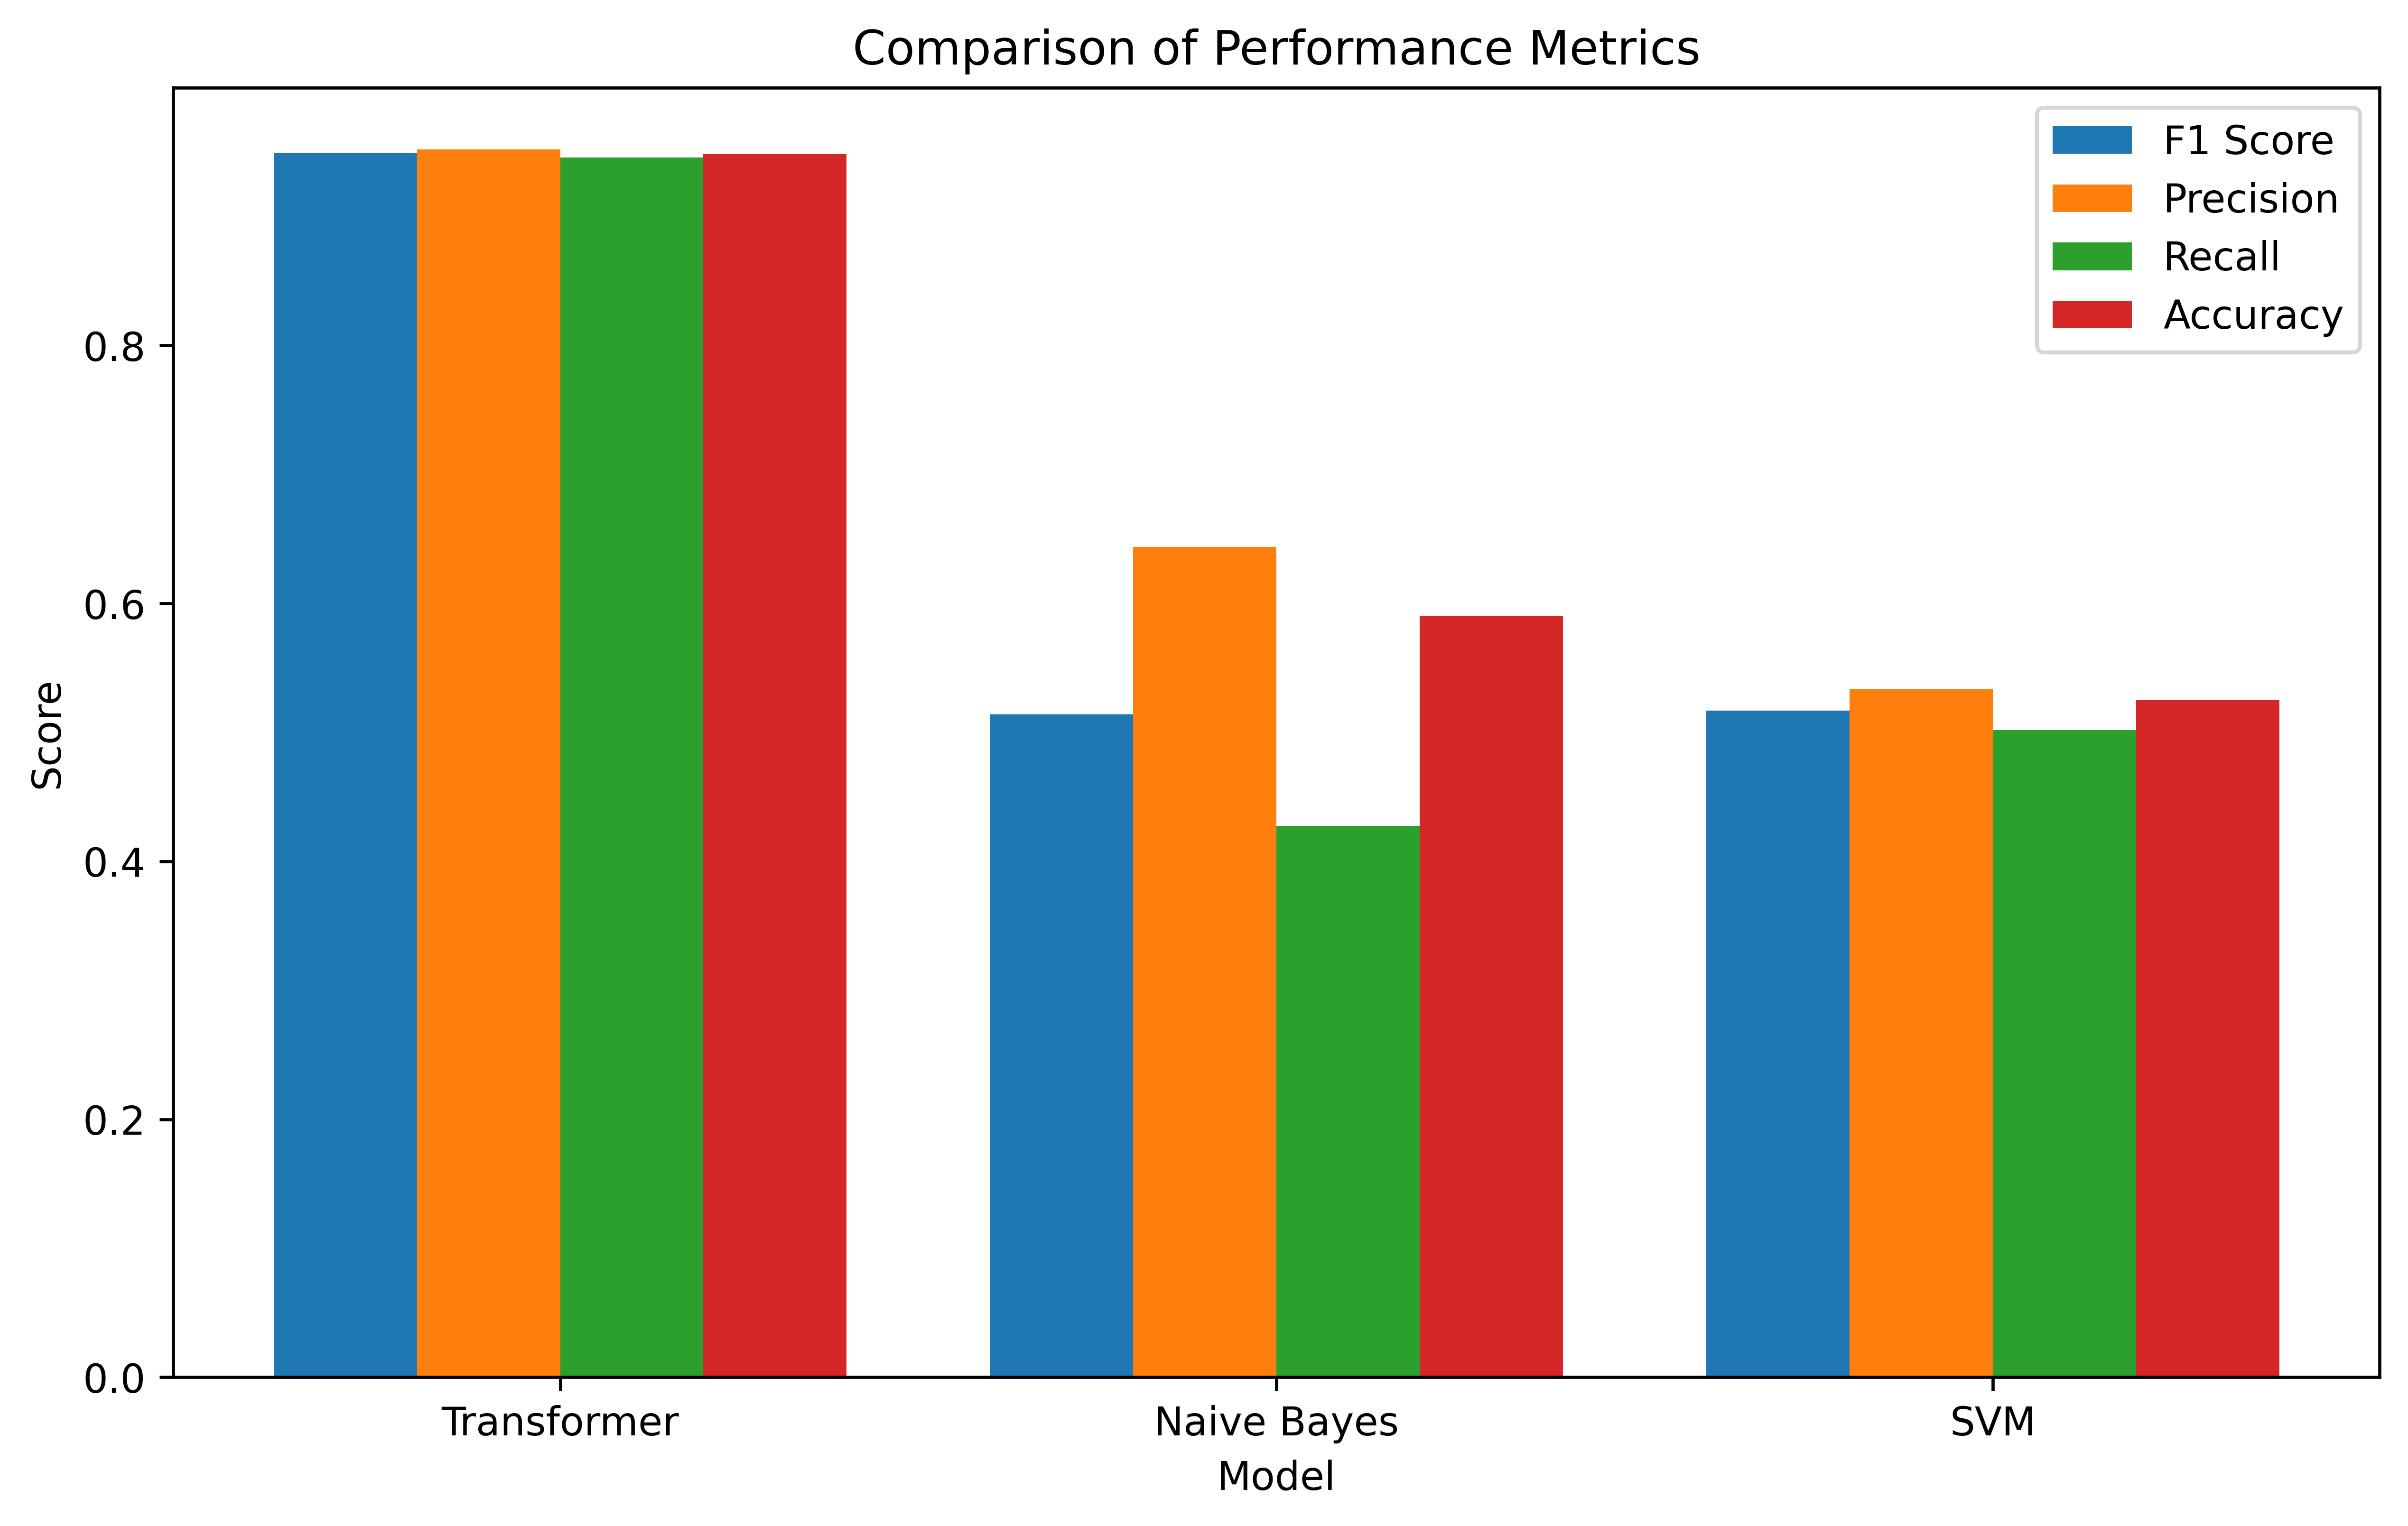

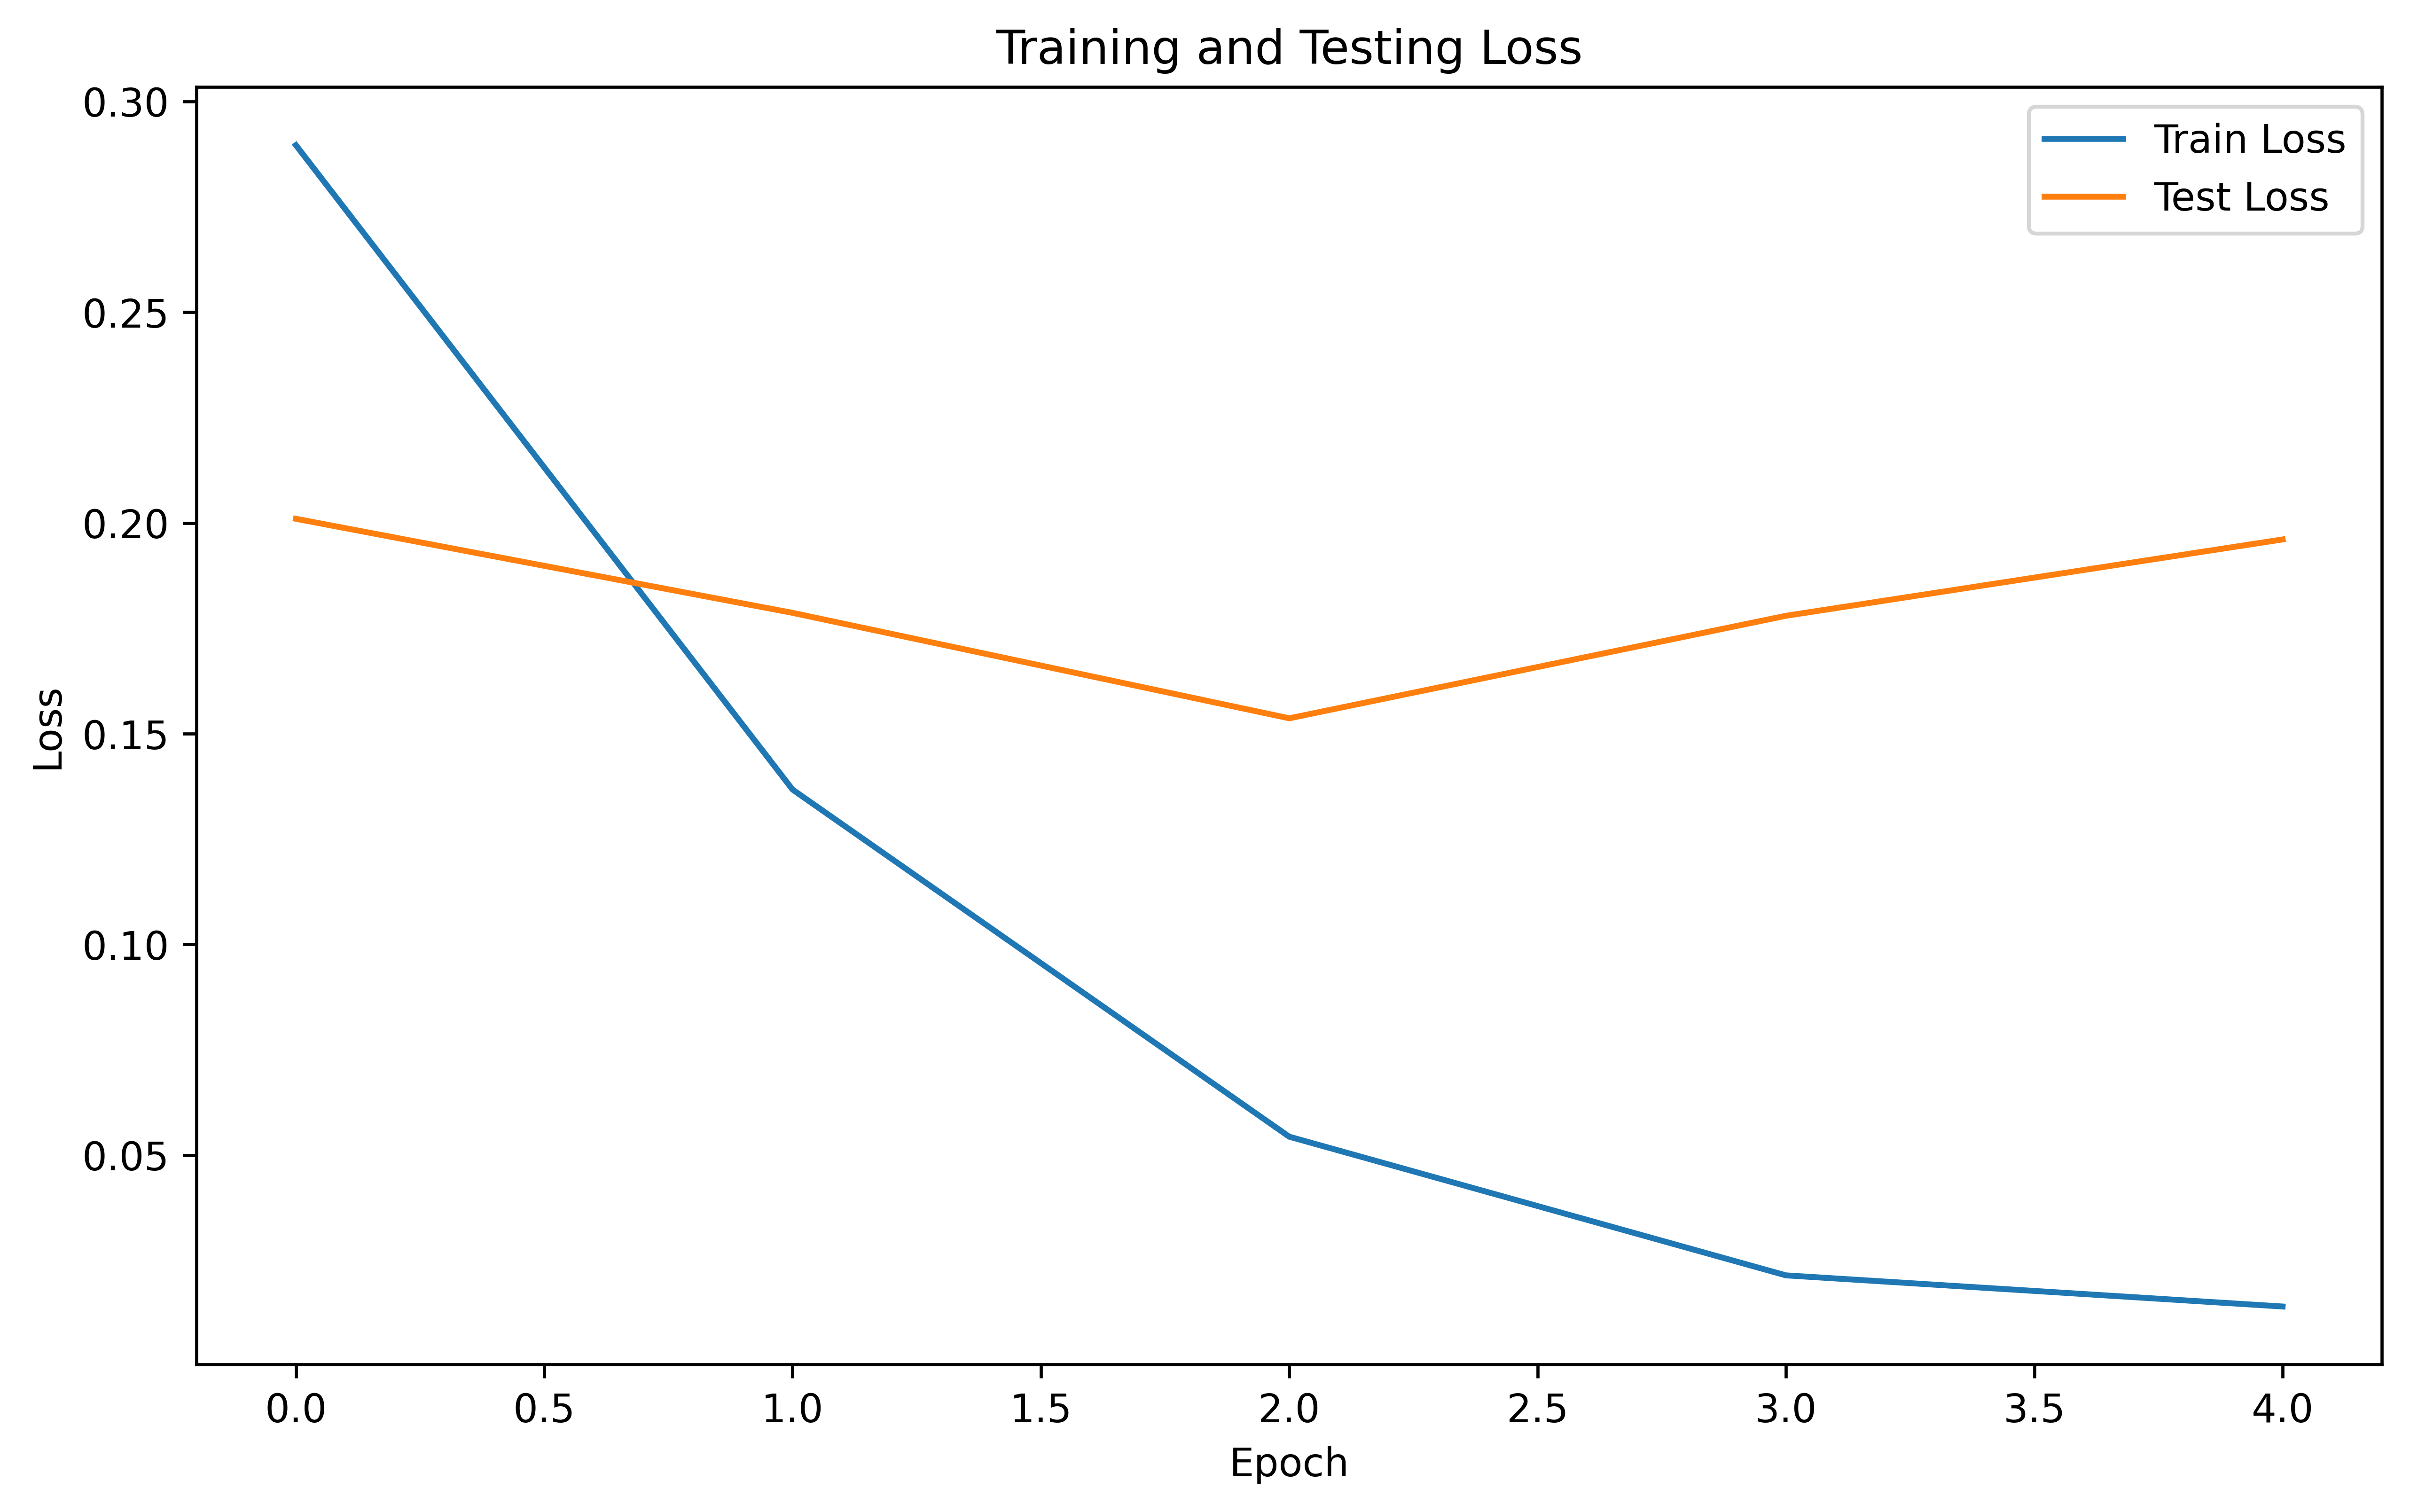

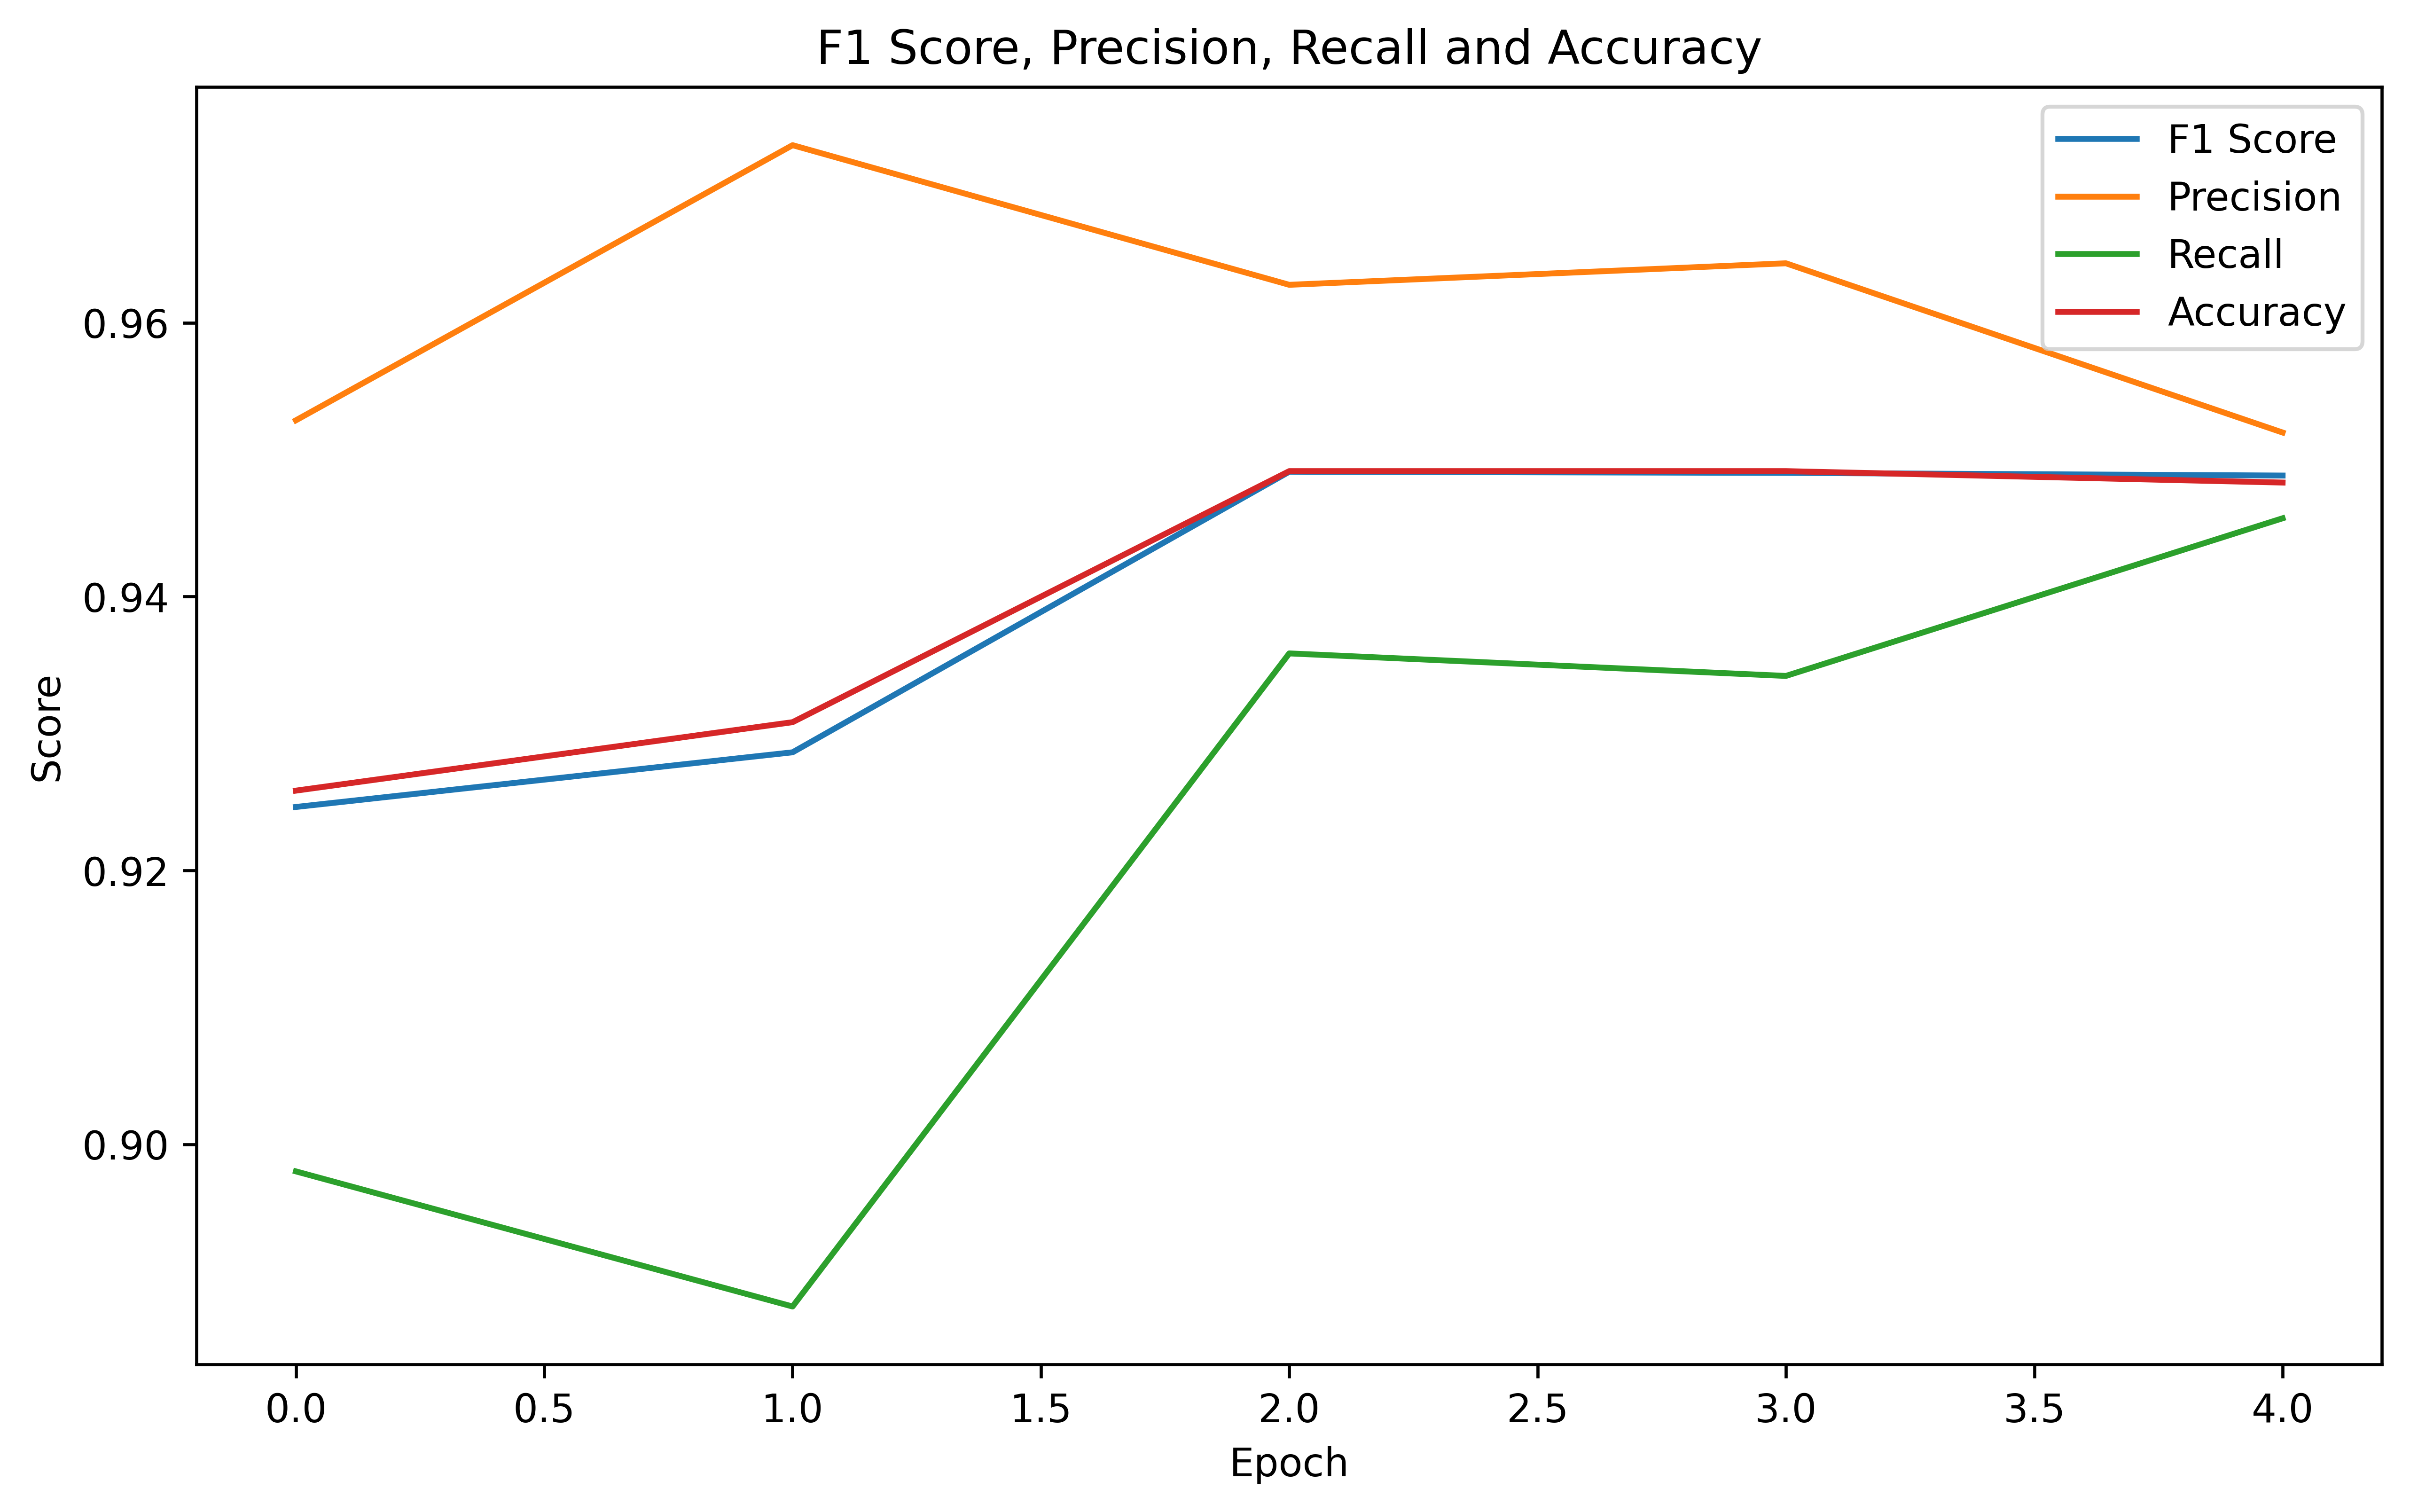

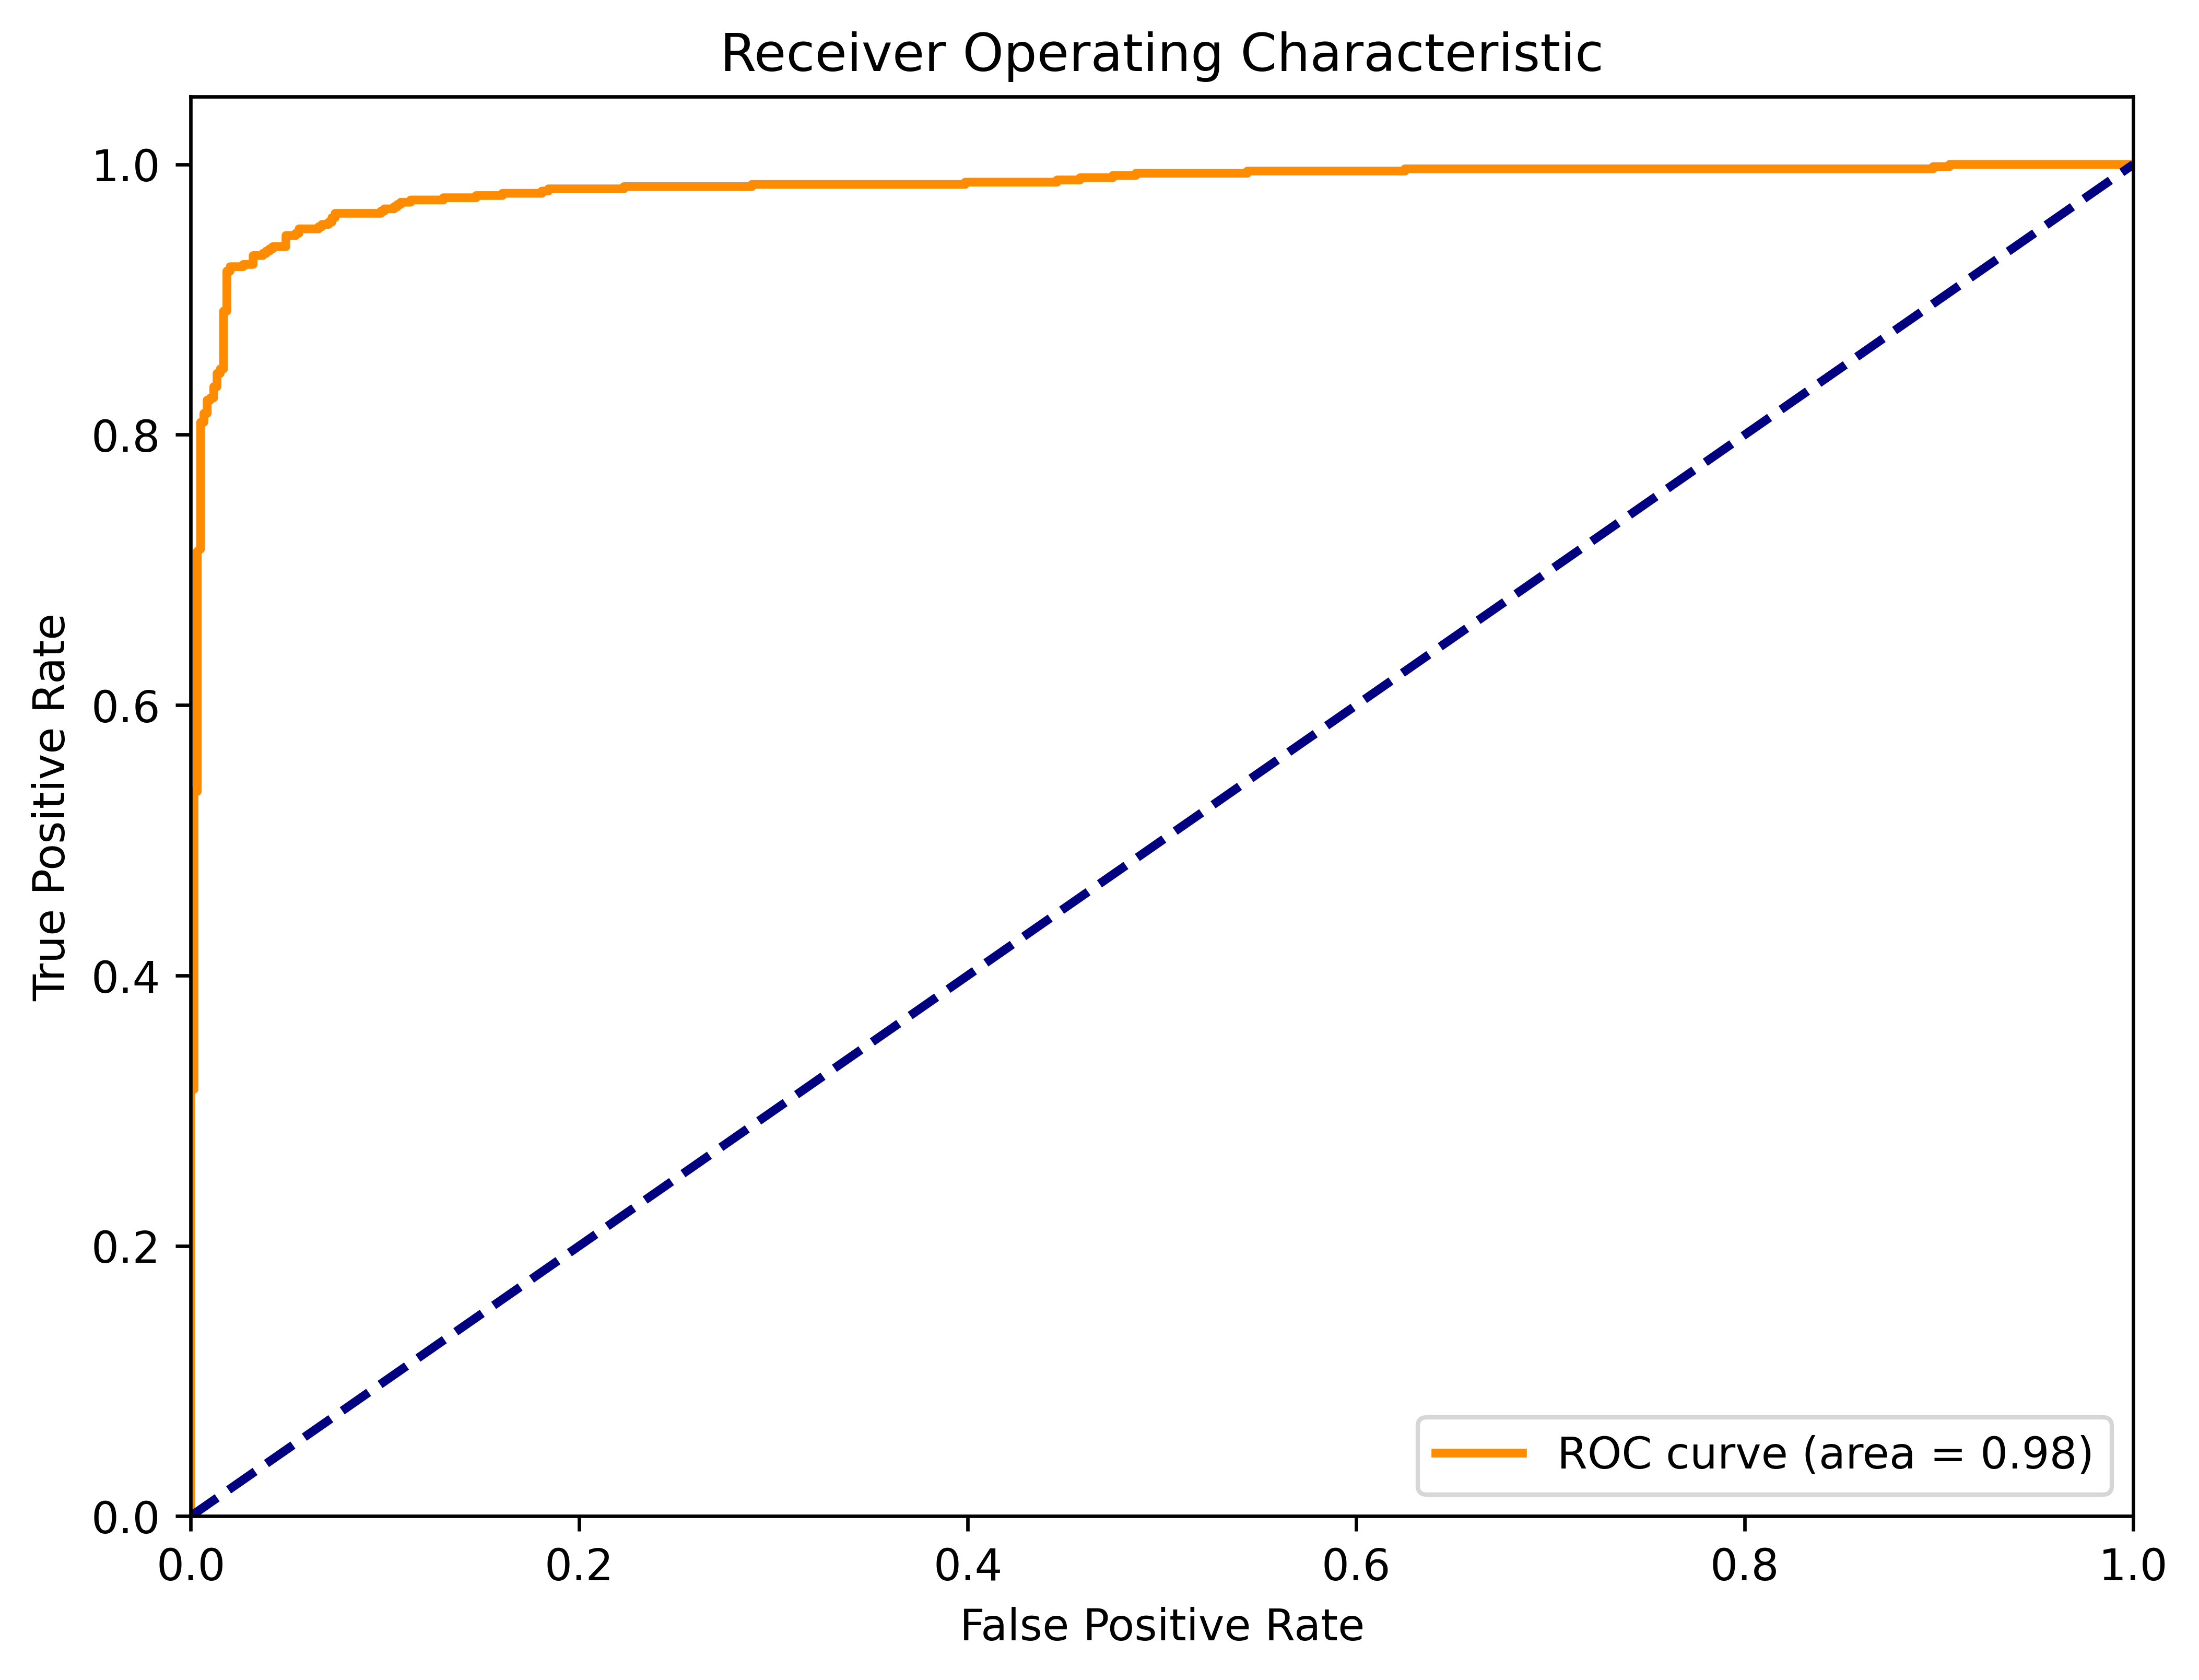

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)



# 自定义数据集
class ChnsenticorpDataset(Dataset):
    def __init__(self, data_path, tokenizer, max_length):
        self.data = pd.read_csv(data_path, delimiter='\t')
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.loc[idx, 'text_a']
        label = self.data.loc[idx, 'label']
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = inputs['input_ids'][0]
        attention_mask = inputs['attention_mask'][0]
        return input_ids, attention_mask, label


# 自定义Transformer模型
class CustomTransformer(nn.Module):
    def __init__(self, pretrained_model_name, num_classes):
        super(CustomTransformer, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask)
        logits = self.classifier(outputs.last_hidden_state[:, 0, :])
        return logits


# 准确率、精确率、召回率、F1分数计算
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1


# 绘制指标曲线
def plot_metrics(metrics, ylabel, title):
    plt.figure(figsize=(8, 6), dpi=600)
    plt.plot(metrics)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


# ROC曲线和AUC计算
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6), dpi=600)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


# 训练和测试函数
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, device, num_epochs):
    model.train()
    train_losses = []
    test_losses = []
    test_f1_scores = []
    test_precisions = []
    test_recalls = []
    test_accuracies = []

    for epoch in range(num_epochs):
        total_train_loss = 0

        # 进度条
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
        for batch_idx, batch in progress_bar:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            # 更新进度条信息
            progress_bar.set_postfix({'Train Loss': total_train_loss / (batch_idx + 1)})

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_test_loss = 0
        y_true = []
        y_pred = []

        with torch.no_grad():
            for batch in test_loader:
                input_ids, attention_mask, labels = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)
                total_test_loss += loss.item()

                probs = torch.nn.functional.softmax(logits, dim=-1)
                predictions = torch.argmax(probs, dim=-1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predictions.cpu().numpy())

        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        accuracy, precision, recall, f1 = compute_metrics(y_true, y_pred)
        test_f1_scores.append(f1)
        test_precisions.append(precision)
        test_recalls.append(recall)
        test_accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, "
              f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # 保存模型
    torch.save(model.state_dict(), 'model.pth')

    return train_losses, test_losses, test_f1_scores, test_precisions, test_recalls, test_accuracies

def train_and_evaluate_naive_bayes(train_data, train_labels, test_data, test_labels):
    # 初始化朴素贝叶斯模型
    nb_model = MultinomialNB()
    nb_model.fit(train_data, train_labels)

    # 在测试集上进行预测
    nb_predictions = nb_model.predict(test_data)

    # 计算性能指标
    nb_accuracy, nb_precision, nb_recall, nb_f1 = compute_metrics(test_labels, nb_predictions)

    return nb_accuracy, nb_precision, nb_recall, nb_f1


def train_and_evaluate_svm(train_data, train_labels, test_data, test_labels):
    # 初始化SVM模型
    svm_model = svm.SVC()
    svm_model.fit(train_data, train_labels)

    # 在测试集上进行预测
    svm_predictions = svm_model.predict(test_data)

    # 计算性能指标
    svm_accuracy, svm_precision, svm_recall, svm_f1 = compute_metrics(test_labels, svm_predictions)

    return svm_accuracy, svm_precision, svm_recall, svm_f1

def main():
    # 参数设置
    data_dir = './datasets/'
    pretrained_model_name = 'bert-base-chinese'
    max_length = 128
    batch_size = 128
    num_classes = 2
    num_epochs = 5
    learning_rate = 2e-5
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 读取数据
    tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)
    train_dataset = ChnsenticorpDataset(data_dir + 'train.tsv', tokenizer, max_length)
    test_dataset = ChnsenticorpDataset(data_dir + 'test.tsv', tokenizer, max_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 初始化模型、优化器、损失函数
    model = CustomTransformer(pretrained_model_name, num_classes).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # 训练和评估Transformer模型
    train_losses, test_losses, test_f1_scores, test_precisions, test_recalls, test_accuracies = train_and_evaluate(
        model, train_loader, test_loader, optimizer, criterion, device, num_epochs
    )

    # 提取Transformer模型的性能指标
    transformer_f1_score = test_f1_scores[-1]
    transformer_precision = test_precisions[-1]
    transformer_recall = test_recalls[-1]
    transformer_accuracy = test_accuracies[-1]

    # 训练和评估朴素贝叶斯模型
    nb_train_data = np.concatenate([train_data[0].numpy() for train_data in train_loader])
    nb_train_labels = np.concatenate([train_data[2].numpy() for train_data in train_loader])
    nb_test_data = np.concatenate([test_data[0].numpy() for test_data in test_loader])
    nb_test_labels = np.concatenate([test_data[2].numpy() for test_data in test_loader])

    nb_accuracy, nb_precision, nb_recall, nb_f1 = train_and_evaluate_naive_bayes(
        nb_train_data, nb_train_labels, nb_test_data, nb_test_labels
    )

    # 训练和评估SVM模型
    svm_accuracy, svm_precision, svm_recall, svm_f1 = train_and_evaluate_svm(
        nb_train_data, nb_train_labels, nb_test_data, nb_test_labels
    )

    # 绘制柱状图
    models = ['Transformer', 'Naive Bayes', 'SVM']
    f1_scores = [transformer_f1_score, nb_f1, svm_f1]
    precisions = [transformer_precision, nb_precision, svm_precision]
    recalls = [transformer_recall, nb_recall, svm_recall]
    accuracies = [transformer_accuracy, nb_accuracy, svm_accuracy]

    x = np.arange(len(models))

    plt.figure(figsize=(10, 6), dpi=600)
    plt.bar(x, f1_scores, width=0.2, label='F1 Score')
    plt.bar(x + 0.2, precisions, width=0.2, label='Precision')
    plt.bar(x + 0.4, recalls, width=0.2, label='Recall')
    plt.bar(x + 0.6, accuracies, width=0.2, label='Accuracy')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Comparison of Performance Metrics')
    plt.xticks(x + 0.3, models)
    plt.legend()
    plt.show()
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 6), dpi=600)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()
    plt.show()

    # 绘制F1 Score、Precision和Recall曲线
    plt.figure(figsize=(10, 6), dpi=600)
    plt.plot(test_f1_scores, label='F1 Score')
    plt.plot(test_precisions, label='Precision')
    plt.plot(test_recalls, label='Recall')
    plt.plot(test_accuracies, label ='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('F1 Score, Precision, Recall and Accuracy')
    plt.legend()
    plt.show()

    # 计算预测概率
    model.eval()
    y_true = []
    y_score = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            logits = model(input_ids, attention_mask)
            probs = torch.nn.functional.softmax(logits, dim=-1)[:, 1]  # 只取正类的概率
            y_score.extend(probs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # 绘制ROC曲线和计算AUC
    plot_roc_curve(y_true, y_score)


if __name__ == '__main__':
    main()